In [1]:
import gym
import random
import numpy as np
from random import randint
from statistics import mean, median
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
env = gym.make("CartPole-v0")
env.reset()
goal_steps = 200
score_requirement = 50
initial_games = 10000

In [3]:
def create_data():
    training_data, scores, accepted_scores = [], [], []
    for _ in range(initial_games):
        score = 0
        game_memory, prev_observation = [], []
        for _ in range(goal_steps):
            action = random.randrange(0,2)
            observation, reward, done, info = env.step(action)
            
            if len(prev_observation) > 0:
                game_memory.append([prev_observation, action])
                
            prev_observation = observation
            score += reward
            
            if done:
                break
            
        if score >= score_requirement:
            accepted_scores.append(score)
            for data in game_memory:
                training_data.append(data)
                    
        env.reset()        
        scores.append(score)
       
    print('Average accepted score:', mean(accepted_scores))
    print('Median accepted score:', median(accepted_scores))
    print(Counter(accepted_scores))
        
    return training_data

In [4]:
def create_initial_pop(pop_size):
    initial_pop = np.random.uniform(low = -3.0, high = 3.0, size = pop_size)
    print('Initial Population:\n{}'.format(initial_pop))
    return initial_pop

In [5]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [6]:
def predict(X):
    pred = np.empty((X.shape[0], 1))
    for i in range(X.shape[0]):
        if X[i] >= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
    return pred    

In [7]:
def cal_fitness(population, X, y, pop_size):
    fitness = np.empty((pop_size[0], 1))
    for i in range(pop_size[0]):
        hx  = X@(population[i]).T
        fitness[i][0] = np.sum(hx)
        
    return fitness

In [8]:
def selection(population, fitness, num_parents):
    fitness = list(fitness)
    parents = np.empty((num_parents, population.shape[1]))
    for i in range(num_parents):
        max_fitness_idx = np.where(fitness == np.max(fitness))
        parents[i,:] = population[max_fitness_idx[0][0], :]
        fitness[max_fitness_idx[0][0]] = -999999
    return parents

In [9]:
def crossover(parents, num_offsprings):
    offsprings = np.empty((num_offsprings, parents.shape[1]))
    crossover_point = int(parents.shape[1]/2)
    crossover_rate = 0.8
    i=0
    while (parents.shape[0] < num_offsprings):
        parent1_index = i%parents.shape[0]
        parent2_index = (i+1)%parents.shape[0]
        x = random.random()
        if x > crossover_rate:
            continue
        parent1_index = i%parents.shape[0]
        parent2_index = (i+1)%parents.shape[0]
        offsprings[i,0:crossover_point] = parents[parent1_index,0:crossover_point]
        offsprings[i,crossover_point:] = parents[parent2_index,crossover_point:]
        i=+1
    return offsprings    


In [10]:
def mutation(offsprings):
    mutants = np.empty((offsprings.shape))
    mutation_rate = 0.4
    for i in range(mutants.shape[0]):
        random_value = random.random()
        mutants[i,:] = offsprings[i,:]
        if random_value > mutation_rate:
            continue
        int_random_value = randint(0,offsprings.shape[1]-1)    
        mutants[i,int_random_value] += np.random.uniform(-1.0, 1.0, 1)
        
    return mutants
    

In [118]:
def GA_model(training_data):
    X = np.array([i[0] for i in training_data])
    y = np.array([i[1] for i in training_data]).reshape(-1, 1)
    fitness_history, weights = [], []
    num_solutions = 8
    pop_size = (num_solutions, X.shape[1])
    num_parents = int(pop_size[0]/2)
    num_offsprings = pop_size[0] - num_parents 
    num_generations = 60
    
    population = create_initial_pop(pop_size)
    
    for i in range(num_generations):
        fitness = cal_fitness(population, X, y, pop_size)
        fitness_history.append(fitness)
        parents = selection(population, fitness, num_parents)
        offsprings = crossover(parents, num_offsprings)
        mutants = mutation(offsprings)
        population[0:parents.shape[0], :] = parents
        population[parents.shape[0]:, :] = mutants
    
    fitness_last_gen = cal_fitness(population, X, y, pop_size)
    max_fitness = np.where(fitness_last_gen == np.max(fitness_last_gen))
    weights.append(population[max_fitness[0][0],:])
    return weights, fitness_history, num_generations

In [119]:
training_data = create_data()

In [135]:
weights, fitness_history, num_generations = GA_model(training_data)
print('Weights: {}'.format(weights))
weights = np.asarray(weights)

Initial Population:
[[-1.31083136  1.04555075 -2.42149709 -2.62211897]
 [ 2.04888369  1.27104369 -2.13124189 -1.18396978]
 [ 0.86216552  2.47219001 -1.82061028 -2.93431775]
 [ 2.29298034  0.59839055 -2.53801776 -1.9615763 ]
 [-2.780734   -0.58975404 -1.32656042  0.88197146]
 [-0.19364708 -1.37167922 -0.49940276 -0.69836454]
 [-2.14847083 -0.21368096 -2.68013172 -0.16231674]
 [ 0.721753   -0.19522049  1.51743169 -0.19506849]]
Weights: [array([ 47.0311387 ,  58.78456129,   7.67296116, -22.73499841])]


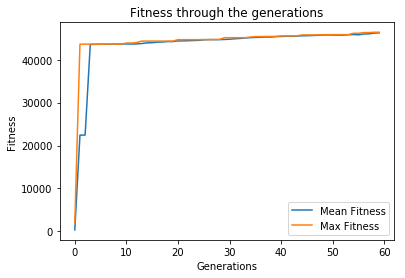

In [136]:
fitness_history_mean = [np.mean(fitness) for fitness in fitness_history]
fitness_history_max = [np.max(fitness) for fitness in fitness_history]
plt.plot(list(range(num_generations)), fitness_history_mean, label = 'Mean Fitness')
plt.plot(list(range(num_generations)), fitness_history_max, label = 'Max Fitness')
plt.legend()
plt.title('Fitness through the generations')
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.show()

In [137]:
def GA_model_predict(test_data, weights):
    hx = sigmoid(test_data@(weights).T)
    pred = predict(hx)
    pred = pred.astype(int)
    return pred[0][0]

In [138]:
scores, choices = [], []
for each_game in range(10):
    score = 0
    game_memory, prev_obs = [], []
    env.reset()
    for _ in range(goal_steps):
        env.render()
        if len(prev_obs) == 0:
            action = random.randrange(0,2)
        else:
            action = GA_model_predict(prev_obs, weights)
        choices.append(action)    
        new_observation, reward, done, info = env.step(action)
        prev_obs = new_observation
        game_memory.append([new_observation, action])
        score += reward
        if done:
            break
    scores.append(score)        
print('Average Score:',print('Average Score:',np.mean(scores)))
print(score_requirement)
print(scores)
    

Average Score: 97.4
Average Score: None
50
[61.0, 75.0, 109.0, 37.0, 200.0, 39.0, 39.0, 121.0, 140.0, 153.0]


In [139]:
env.close()